In [1]:
import pickle
import torch
import numpy as np
from StructuralProbe import StructuralProbe
from POSProbe import POSProbe
from collections import defaultdict
from tree_utils import calc_uuas
%load_ext autoreload
%autoreload 2
with open("FINALS.pickle", "rb") as f:
    result_dict = pickle.load(f)
    
with open("XLguysDEPLR5More.pickle", "rb") as f:
    lowlr_dict = pickle.load(f)
    
    
with open("XLBoysPOSLR5More.pickle", "rb") as f:
    lowlr_dict2 = pickle.load(f)
    lowlr_dict['pos'] = lowlr_dict2['pos']
    lowlr_dict['controlpos'] = lowlr_dict2['controlpos']    

In [3]:
from tree_utils import create_or_load_structural_data
import torch.utils.data as data
import math

from datasets import * 
device = 'cuda:0'
def mean_test_acc(the_dict):
    """Averages uuas score or accuracy on test set over three seeds"""
    three_accs = [the_dict[z]['test_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

def mean_dev_acc(the_dict):
    """Averages uuas score or accuracy on dev set over three seeds"""
    three_accs = [the_dict[z]['dev_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

def uuas_per_length(model, test_loader):
    length_amount_dict = defaultdict(lambda:0)
    length_uuas_dict = defaultdict(lambda:0)
    result = dict()
    model.eval()
    with torch.no_grad():
        for distances, embs, lengths in test_loader:
            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)

            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)
            outputs = model(embs)
            l = lengths[0].item()
            preds = outputs[0,0:l, 0:l]
            gold = distances[0,0:l, 0:l]

            u = calc_uuas(preds, gold)
            if not math.isnan(u):
                length_amount_dict[l] +=1
                length_uuas_dict[l] += u
    result2 = {}
    for k in sorted(list(length_uuas_dict.keys())):
        result[k] = length_uuas_dict[k]/length_amount_dict[k]
        result2[k] = result[k] / k
    #print([z for z in sorted(length_amount_dict.items())])
    #print([z for z in sorted(result.items())])
    return result, length_amount_dict


def uuas_length_averaged_per_seed(model, test_loader):
    """Collects uuas score per sentence length in a dict and averaged over three seeds"""
    result = defaultdict(lambda:0)
    result2 = defaultdict(lambda:0)
    seeds = 0
    for seed in model:
        seeds +=1
        specific_results, specific_results2 = uuas_per_length(model[seed]['state_dict'], test_loader)
        for k in specific_results:
            result[k] += specific_results[k]
            
        for k in specific_results2:
            result2[k] += specific_results2[k]
    for k in result:
        result[k] /= seeds
        result2[k] /= seeds
    return result, result2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0, 0.2, 0.4, 0.6, 0.8] [0.8981112527892892, 0.9026670917012006, 0.8997715439379449, 0.8811762830729997, 0.8187626182127298] [0.22298374242907248, 0.22169535649771532, 0.25383859313569224, 0.30073849750292203, 0.3525661459993624]
[0, 0.2, 0.4, 0.6, 0.8] [0.9276511529061736, 0.9277574115396877, 0.92260386781426, 0.8868744022951865, 0.762764318350866] [0.24904367229837432, 0.2687413664860271, 0.314299755605143, 0.3493916693231325, 0.3869275316119435]
[0, 0.2, 0.4, 0.6, 0.8] [0.8273031558814153, 0.8263866751673573, 0.7978960790564233, 0.7352566145999363, 0.5915285304430985] [0.28143927319094675, 0.26621772394007004, 0.26745298055467004, 0.26091807459356076, 0.2207921581128467]
[0, 0.2, 0.4, 0.6, 0.8] [0.8903809372011476, 0.8907926894060143, 0.8848422059292318, 0.8467883328020402, 0.7119062798852407] [0.26773190946764425, 0.2568271172032728, 0.2823557539050049, 0.3108994793326958, 0.30704760386781427]


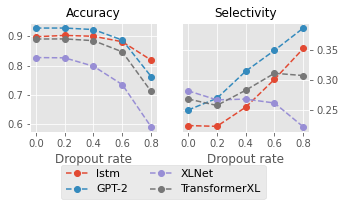

In [112]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

"""
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3))

for model in ['lstm', 'transformer', 'XLNet', 'TransformerXL']:
    for hidden_size in [256]:
        x_axis = [0,0.2,0.4,0.6,0.8]
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in x_axis :
            # Mean for POS task
            mean = mean_test_acc(result_dict['pos'][model][hidden_size][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(result_dict['controlpos'][model][hidden_size][d])
            #print(model, mean, mean_control)
            # Append
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])

        ax1.plot(x_axis, y_axis, '--o', label=model if model != 'transformer' else 'gpt2', )
        ax2.plot(x_axis, y_axis_select, '--o', label=model if model != 'transformer' else 'gpt2',)
        ax2.legend(fontsize=16, bbox_to_anchor=(1,1))
        
    
ax1.set_title("Accuracy", fontsize=18)
ax2.set_title("Selectivity", fontsize=18)
"""
#plt.tight_layout()
#plt.show()


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5,2))

ANALYZE_DROPOUT = True
h_list = [256]
d_list = [0,0.2,0.4,0.6,0.8]
for model in ['lstm', 'transformer', 'LRXLNet', 'TransformerXL']:#, 'LRXLNet', 'LRTransformerXL']:
    if 'LR' not in model:
        the_dict = result_dict
        lr = False
    else:
        the_dict = lowlr_dict
        model = model[2:]
        lr = True
        
    for h in h_list:
        x_axis = []
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in d_list:
            # Mean for POS task
            mean = mean_test_acc(the_dict['pos'][model][h][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(the_dict['controlpos'][model][h][d])
            #print(model, mean, mean_control)
            # Append
            x_axis.append(d)
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])
        print(x_axis, y_axis, y_axis_select)
        model_name = (model if model != 'transformer' else 'GPT-2')
        #model_name = model_name if not lr else model_name +'lr'
        ax1.plot(x_axis, y_axis, '--o', label=model_name, )
        ax2.plot(x_axis, y_axis_select, '--o', label=model_name,)
        z = ax2.legend(fontsize=11, bbox_to_anchor=(0.7,-0.25), ncol=2)
        #ax1.set_ylim(0.3,0.8)
        #ax2.set_ylim(0.1,0.25)
ax1.set_xticks([0,0.2,0.4,0.6,0.8])
ax2.set_xticks([0,0.2,0.4,0.6,0.8])
ax1.set_title("Accuracy", fontsize=12)
ax2.set_title("Selectivity", fontsize=12)
ax2.yaxis.tick_right()
ax1.set_xlabel("Dropout rate", fontsize=12)
ax2.set_xlabel("Dropout rate", fontsize=12)
plt.savefig('pos_select.eps', format='eps',  dpi=1200,  bbox_extra_artists=(z,), bbox_inches='tight')
#plt.tight_layout()
#plt.show()


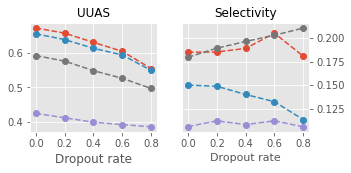

In [110]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5,2))


for model in ['lstm', 'transformer', 'XLNet', 'TransformerXL']: #, 'LRXLNet', 'LRTransformerXL']:
    if 'LR' not in model:
        the_dict = result_dict
        lr = False
    else:
        the_dict = lowlr_dict
        model = model[2:]
        lr = True
        
    if ANALYZE_DROPOUT:
        d_list = [0,0.2,0.4,0.6,0.8]
        h_list = [64]
    else:
        d_list = [0]
        h_list = [16,64,128]
        
    for h in h_list:
        x_axis = []
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in d_list :
            # Mean for POS task
            mean = mean_test_acc(the_dict['dep'][model][h][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(the_dict['controldep'][model][h][d])
            #print(model, mean, mean_control)
            # Append
            x_axis.append(d)
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])
            
        model_name = (model if model != 'transformer' else 'GPT-2')
        model_name = model_name if not lr else model_name +'lr'
        ax1.plot(x_axis, y_axis, '--o', label=model_name, )
        ax2.plot(x_axis, y_axis_select, '--o', label=model_name,)
        #ax2.legend(fontsize=16, bbox_to_anchor=(1,1))
        #ax1.set_ylim(0.3,0.8)
        #ax2.set_ylim(0.1,0.25)
#ax2.legend(fontsize=12, bbox_to_anchor=(1,1))   
ax1.set_title("UUAS", fontsize=12)
ax2.set_title("Selectivity", fontsize=12)
ax2.yaxis.tick_right()
ax1.set_xticks([0,0.2,0.4,0.6,0.8])
ax2.set_xticks([0,0.2,0.4,0.6,0.8])
ax1.set_xlabel("Dropout rate", fontsize=12)
ax2.set_xlabel("Dropout rate", fontsize=11)
plt.savefig('dep_select.eps', format='eps',  dpi=1200, bbox_inches='tight')
plt.show()


In [96]:
result_dict['dep']['XLNet'][16][0]

{10: {'state_dict': StructuralProbe(
    (dropout): Dropout(p=0, inplace=False)
  ),
  'dev_acc': 0.4191334460112989,
  'test_acc': 0.4158114450473195,
  'epochs': 11},
 20: {'state_dict': StructuralProbe(
    (dropout): Dropout(p=0, inplace=False)
  ),
  'dev_acc': 0.4150395013903099,
  'test_acc': 0.4092016391180347,
  'epochs': 9},
 30: {'state_dict': StructuralProbe(
    (dropout): Dropout(p=0, inplace=False)
  ),
  'dev_acc': 0.41516261417250655,
  'test_acc': 0.40679100977736393,
  'epochs': 2}}

In [7]:
gpt2embs = create_or_load_structural_data("test", None, None, extra_transformer='GPT2')
lstmembs = create_or_load_structural_data("test", None, None, extra_transformer='RNN')
xlnetembs = create_or_load_structural_data("test", None, None, extra_transformer='XLNet')
transformerxlembs = create_or_load_structural_data("test", None, None, extra_transformer='TransformerXL')

test_loader_gpt2 = data.DataLoader(StructuralDataset(*gpt2embs), batch_size=1, shuffle=False)
test_loader_lstm = data.DataLoader(StructuralDataset(*lstmembs), batch_size=1, shuffle=False)
test_loader_xlnet = data.DataLoader(StructuralDataset(*xlnetembs), batch_size=1, shuffle=False)
test_loader_transformerxl = data.DataLoader(StructuralDataset(*transformerxlembs), batch_size=1, shuffle=False)

USING SAVE FILE corpus/transformer_structuraltest.pickle
USING SAVE FILE corpus/RNN_structuraltest.pickle
USING SAVE FILE corpus/transformer_structuraltest_XLNet.pickle
USING SAVE FILE corpus/transformer_structuraltest_TransformerXL.pickle


In [ ]:

# 64,0 are best hyperparams for each
lrxlnet, _ = uuas_length_averaged_per_seed(lowlr_dict['dep']['XLNet'][128][0.8], test_loader_xlnet)
lrtransformerxl, _ = uuas_length_averaged_per_seed(lowlr_dict['dep']['XLNet'][128][0], test_loader_transformerxl)

gpt2, ngpt2  = uuas_length_averaged_per_seed(result_dict['dep']['transformer'][64][0], test_loader_gpt2)
rnn, nrnn = uuas_length_averaged_per_seed(result_dict['dep']['lstm'][64][0], test_loader_lstm)
xlnet, nxlnet = uuas_length_averaged_per_seed(result_dict['dep']['XLNet'][64][0], test_loader_xlnet)
txl, ntxl = uuas_length_averaged_per_seed(result_dict['dep']['TransformerXL'][64][0], test_loader_transformerxl)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


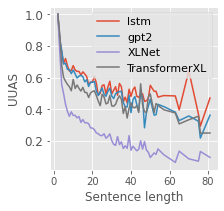

In [118]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1,1, figsize=(3,3))

ax1.plot(*zip(*rnn.items()), label='lstm')
ax1.plot(*zip(*gpt2.items()), label='gpt2')
ax1.plot(*zip(*xlnet.items()), label='XLNet')
ax1.plot(*zip(*txl.items()), label='TransformerXL')
#ax1.plot(*zip(*lrxlnet.items()), label='XLNetLR')
#ax1.plot(*zip(*lrtransformerxl.items()), label='TransformerXLLR')

#ax2.plot(*zip(*ngpt2.items()), label='gpt2')
#ax2.plot(*zip(*nrnn.items()), label='lstm')
#ax2.plot(*zip(*nxlnet.items()), label='xlnet')
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax1.legend(fontsize=11,)
ax1.set_xlabel("Sentence length",fontsize=12)
ax1.set_ylabel("UUAS", fontsize=12)
plt.savefig('lengths.eps', format='eps',  dpi=1200,  bbox_extra_artists=(z,), bbox_inches='tight')
#plt.show()

In [120]:
import scipy.stats


def get_slope(modeldict):
    xs1 = np.array(list(modeldict.keys()))
    ys1 = np.array(list(modeldict.values()))
    xs = np.array(list(modeldict.keys())[6:30])
    ys = np.array(list(modeldict.values())[6:30])
    return scipy.stats.linregress(xs, ys).slope, scipy.stats.linregress(xs1, ys1).slope

def decrease(modeldict):
    avg_acc1 = 0
    avg_acc2 = 0
    range1 = range(6,16)
    range2 = range(16,30)
    total_len = 0
    for i in range1 :
        avg_acc1 += modeldict[i] * nrnn[i]
        total_len += nrnn[i]
        
    total_len2 = 0
    for i in range2:
        avg_acc2 += modeldict[i] * nrnn[i] 
        total_len2 += nrnn[i]
    
    avg1 = avg_acc1/total_len
    avg2 = avg_acc2/total_len2
    #print('Percentage of short sentences', total_len/(total_len+total_len2))
    print('Short',round(avg1,3),'Long', round(avg2,3))
    print("Ratio", round(avg2/avg1,3))

print('gpt2', get_slope(gpt2))
decrease(gpt2)

print('rnn', get_slope(rnn))
decrease(rnn)

print('xlnet', get_slope(xlnet))
decrease(xlnet)

print('lrxlnet', get_slope(lrxlnet))
decrease(lrxlnet)

print('transformerxl', get_slope(txl))
decrease(txl)

print('lrtransformerxl', get_slope(lrtransformerxl))
decrease(lrtransformerxl)
    

gpt2 (-0.007423864160867182, -0.005858406052909515)
Short 0.638 Long 0.544
Ratio 0.852
rnn (-0.006861204882335812, -0.0042293759379003395)
Short 0.658 Long 0.566
Ratio 0.861
xlnet (-0.008020740040098834, -0.0062282984010580645)
Short 0.368 Long 0.272
Ratio 0.739
lrxlnet (-0.007147022086868125, -0.005965199950547145)
Short 0.335 Long 0.246
Ratio 0.734
transformerxl (-0.0054010402798957595, -0.0045729605909952025)
Short 0.548 Long 0.485
Ratio 0.886
lrtransformerxl (-0.005278384415699227, -0.00463079219486197)
Short 0.367 Long 0.298
Ratio 0.814


lstm pos 256 0.2 0.9026670917012006 0.22169535649771532
lstm&0.9&0.68&0.22&-0.08&0.13 \\
gpt2 pos 256 0.2 0.9277574115396877 0.2687413664860271
gpt2&0.93&0.66&0.27&-0.16&0.12 \\
XLNet pos 256 0 0.816836680480289 0.25978907661247475
XLNet&0.82&0.56&0.26&-0.48&-0.14 \\
TransformerXL pos 256 0.2 0.8907926894060143 0.2568271172032728
TXL&0.89&0.63&0.26&-0.18&0.05 \\
LRXLNet pos 256 0 0.8273031558814153 0.28143927319094675
LRXLNet&0.83&0.55&0.28&-0.24&-0.06 \\
LRTransformerXL pos 256 0.2 0.8863165444692381 0.31829773669110617
LRTXL&0.89&0.57&0.32&-0.11&0.02 \\

lstm dep 64 0 0.6717540982852755 0.18495937536094836
lstm&0.67&0.49&0.18&-0.12&0.0 \\
gpt2 dep 64 0 0.6549281926743292 0.1501442359853704
gpt2&0.65&0.5&0.15&-0.12&-0.05 \\
XLNet dep 64 0 0.4253525171973796 0.10604952522209848
XLNet&0.43&0.32&0.11&-0.04&0.01 \\
TransformerXL dep 64 0 0.5920818066988821 0.17967980331411065
TXL&0.59&0.41&0.18&-0.1&0.03 \\
LRXLNet dep 64 0 0.40919218179748007 0.12676957585332482
LRXLNet&0.41&0.28&0.13&-0

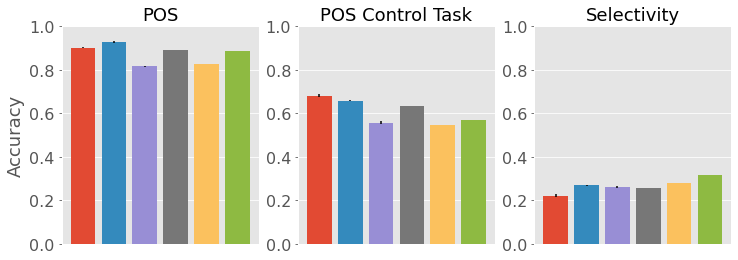

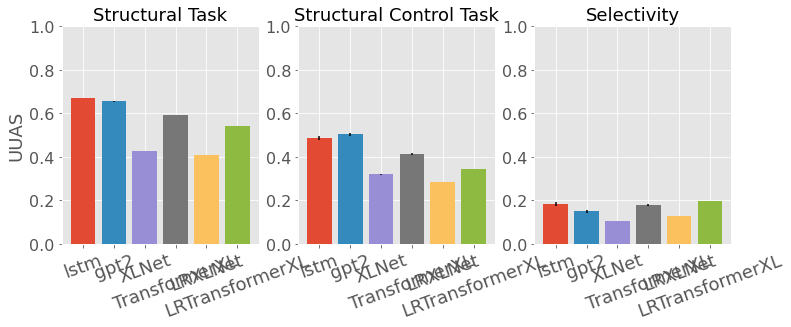

In [75]:
def find_best_dev_given_task_and_model(task, model):
    dim = [0,256] if 'pos' in task else [16,64,128]
    controltask = 'control' + task
    best_dev_acc = 0
    best_dev_selec = 0 
    for hidden_size in dim:
        for dropout in [0,0.2,0.4,0.6,0.8]:
            dev_acc = mean_dev_acc(result_dict[task][model][hidden_size][dropout])[0]
            dev_ctrl = mean_dev_acc(result_dict[controltask][model][hidden_size][dropout])[0]
            dev_selec = dev_acc - dev_ctrl
            if dev_selec > best_dev_selec:
                best_hidden_selec = hidden_size
                best_dropout_selec = dropout
                best_dev_acc_selec = dev_acc
            if dev_acc > best_dev_acc:
                best_hidden = hidden_size
                best_dropout = dropout
                best_dev_acc = dev_acc
    return best_hidden, best_dropout, best_hidden_selec, best_dropout_selec

plt.style.use('ggplot')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))


for model in ['lstm', 'transformer','XLNet', 'TransformerXL','LRXLNet', 'LRTransformerXL']:
    task = 'pos'
    model_lookup=model
    if 'LR' in model:
        the_dict = lowlr_dict
        model_lookup = model[2:]
    else:
        the_dict =result_dict
    h, d, hs, ds = find_best_dev_given_task_and_model(task, model_lookup)
    mean, sd = mean_test_acc(the_dict[task][model_lookup][h][d])
    meanC, sdC = mean_test_acc(the_dict['controlpos'][model_lookup][h][d])
    
    means, sds = mean_test_acc(the_dict[task][model_lookup][hs][ds])
    meanCs, sdCs = mean_test_acc(the_dict['controlpos'][model_lookup][hs][ds])
    if model == 'transformer': model = 'gpt2'
    print(model, task, h,d, mean, mean-meanC)
    #print('&'.join([model] + [str(round(i,2)) for i in [mean,meanC,mean-meanC, means-mean, meanCs-meanC]]), '\\\\')
    print('&'.join([model.replace('ransformer','')] + [str(round(i,2)) for i in [mean,meanC,mean-meanC, means-mean, (means-meanCs)-(mean-meanC)]]), '\\\\')
    
    
    
    #print(model, task, hs,ds, means, means-meanCs)
    ax1.bar(model, mean, yerr= sd, width=0.8)#, label='model')
    ax2.bar(model, meanC, yerr=sdC,width=0.8)#, label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC, width=0.8)#,label='model')

ax1.set_title("POS", fontsize=18)
ax2.set_title("POS Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("Accuracy", fontsize=18)
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_ylim(0,1)
    #ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

#plt.tight_layout()
#plt.savefig('pos.png', format='eps',  dpi=1200)
#plt.show()
print()
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

for model in ['lstm', 'transformer','XLNet', 'TransformerXL','LRXLNet', 'LRTransformerXL']:
    task = 'dep'
    model_lookup=model
    if 'LR' in model:
        the_dict = lowlr_dict
        model_lookup = model[2:]
    else:
        the_dict =result_dict
    h, d, hs, ds = find_best_dev_given_task_and_model(task, model_lookup)
    mean, sd = mean_test_acc(the_dict[task][model_lookup][h][d])
    meanC, sdC = mean_test_acc(the_dict['controldep'][model_lookup][h][d])
    
    means, sds = mean_test_acc(the_dict[task][model_lookup][hs][ds])
    meanCs, sdCs = mean_test_acc(the_dict['controldep'][model_lookup][hs][ds])
    if model == 'transformer': model = 'gpt2'
    print(model, task, h,d, mean, mean -meanC)
    print('&'.join([model.replace('ransformer','')] + [str(round(i,2)) for i in [mean,meanC,mean-meanC, means-mean, (means-meanCs)-(mean-meanC)]]), '\\\\')

    #print(model, task, hs,ds, means, means-meanCs)
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC, width=0.8,label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC,width=0.8, label='model')
    
ax1.set_title("Structural Task", fontsize=18)
ax2.set_title("Structural Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("UUAS", fontsize=18)
    
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=18)
    ax.tick_params(axis='y', labelsize=16)
#plt.savefig('struct.eps', format='eps')

plt.show()

In [ ]:
def find_best_dev_given_task_and_model(task, model):
    dim = [0,256] if 'pos' in task else [16,64,128]
    best_dev_acc = 0
    for hidden_size in dim:
        for dropout in [0,0.2,0.4,0.6,0.8]:
            dev_acc = mean_dev_acc(result_dict[task][model][hidden_size][dropout])[0]
            if dev_acc > best_dev_acc:
                best_hidden = hidden_size
                best_dropout = dropout
                best_dev_acc = dev_acc
    return best_hidden, best_dropout

plt.style.use('ggplot')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))


for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'pos'
    h, d = find_best_dev_given_task_and_model(task, model)
    print(model, task, h,d)
    mean, sd = mean_test_acc(result_dict[task][model][h][d])
    meanC, sdC = mean_test_acc(result_dict['controlpos'][model][h][d])
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC,width=0.8, label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC, width=0.8,label='model')
ax1.set_title("POS", fontsize=18)
ax2.set_title("POS Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("Accuracy", fontsize=16)
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

#plt.tight_layout()
plt.savefig('pos.png', format='eps',  dpi=1200)
#plt.show()

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'dep'
    h, d = find_best_dev_given_task_and_model(task, model)
    print(model, task, h,d)
    mean, sd = mean_test_acc(result_dict[task][model][h][d])
    meanC, sdC = mean_test_acc(result_dict['controldep'][model][h][d])
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC, width=0.8,label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC,width=0.8, label='model')
    
ax1.set_title("Structural Task", fontsize=18)
ax2.set_title("Structural Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("UUAS", fontsize=16)
    
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
plt.savefig('struct.eps', format='eps')
#plt.show()

In [105]:
def acc_per_position(model, test_loader, list_of_positions, list_of_lengths):
    position_amount_dict = defaultdict(lambda:0)
    position_correct_dict = defaultdict(lambda:0)
    result = dict()
    model.eval()
    with torch.no_grad():
        i = 0 
        current_sent = 0
        current_position = 0
        for x, y in test_loader: 
            x = x.to(device)
            y = y.to(device)
            position = list_of_positions[i]
            i += 1
            current_position += 1
            output = model(x)
            pred = torch.argmax(output,dim=1)
            correct = torch.eq(pred, y)
            current_len = list_of_lengths[current_sent]
            #print(current_position, current_len, position/current_len, r)
            relative_position = round(position/current_len, 1)
            if correct.item():
                position_correct_dict[relative_position] += 1
            position_amount_dict[relative_position] += 1
            
            
            if current_position == current_len:
                #print("NEW SENT", current_sent, list_of_lengths[current_sent])
                current_sent += 1
                current_position = 0
                
            
            
    for k in sorted(list(position_amount_dict.keys())):
        result[k] = position_correct_dict[k]/position_amount_dict[k]
    #print([z for z in sorted(result.items())])
    return result, position_amount_dict


def relative_position_averaged_per_seed(model, test_loader, list_of_positions, list_of_lengths):
    """Collects uuas score per sentence length in a dict and averaged over three seeds"""
    result = defaultdict(lambda:0)
    seeds = 0
    for seed in model:
        #print(model[seed]['state_dict'])
        seeds +=1
        specific_results,_ = acc_per_position(model[seed]['state_dict'], test_loader, list_of_positions, list_of_lengths)
        for k in specific_results:
            result[k] += specific_results[k]
            
    for k in result:
        result[k] /= seeds
    return result,

In [107]:
from utils import create_or_load_pos_data
from datasets import POSDataset
from POSProbe import POSProbe

with open('results_pos.pickle', 'rb') as f:
    lstm_dict = pickle.load(f)

gpt2pos = create_or_load_pos_data("test", None, None, extra_transformer='GPT2')
lstmpos = create_or_load_pos_data("test", None, None, extra_transformer='RNN')
xlnetpos = create_or_load_pos_data("test", None, None, extra_transformer='XLNet')
transformerxlpos = create_or_load_pos_data("test", None, None, extra_transformer='TransformerXL')

gptloader = data.DataLoader(POSDataset(gpt2pos[0], gpt2pos[1]), batch_size=1)
lstmloader = data.DataLoader(POSDataset(lstmpos[0], lstmpos[1]), batch_size=1)

list_of_positions = []
list_of_lenghts = []
for i in test_loader_lstm:
    length = i[2].item()
    list_of_lengths.append(length)
    for z in range(length):
        list_of_positions.append(z)

accsLSTM = relative_position_averaged_per_seed( lstm_dict['pos']['lstm'][256][0.2], lstmloader, list_of_positions, list_of_lengths)
accsGPT  = relative_position_averaged_per_seed(lstm_dict['pos']['transformer'][256][0.2], gptloader, list_of_positions, list_of_lengths)
#accsGPT, amounts = acc_per_position(lstm_dict['pos']['transformer'][256][0.2], gptloader, list_of_positions, list_of_lengths)
#accsGPT, amounts = acc_per_position(lstm_dict['pos']['transformer'][256][0.2], gptloader, list_of_positions, list_of_lengths)

#accsXLNET, _ = acc_per_position(lstm_dict['pos']['lstm'][256][0.2][10]['state_dict'], lstmloader, list_of_positions)
#accsTXL, _ = acc_per_position(lstm_dict['pos']['transformer'][256][0.2][10]['state_dict'], gptloader, list_of_positions)



USING SAVE corpus/transformer_postest.pickle
USING SAVE corpus/RNN_postest.pickle
USING SAVE corpus/transformer_postest_XLNet.pickle
USING SAVE corpus/transformer_postest_TransformerXL.pickle


In [108]:
xlnetloader = data.DataLoader(POSDataset(xlnetpos[0], lstmpos[1]), batch_size=1)
txlloader = data.DataLoader(POSDataset(transformerxlpos[0], lstmpos[1]), batch_size=1)
print(xlnetpos[0].shape, xlnetpos[1])

accsXLNET = relative_position_averaged_per_seed(result_dict['pos']['XLNet'][256][0.2], xlnetloader, list_of_positions, list_of_lengths)
accsTXL = relative_position_averaged_per_seed(result_dict['pos']['TransformerXL'][256][0.2], txlloader, list_of_positions , list_of_lengths)


torch.Size([25096, 1024]) 0


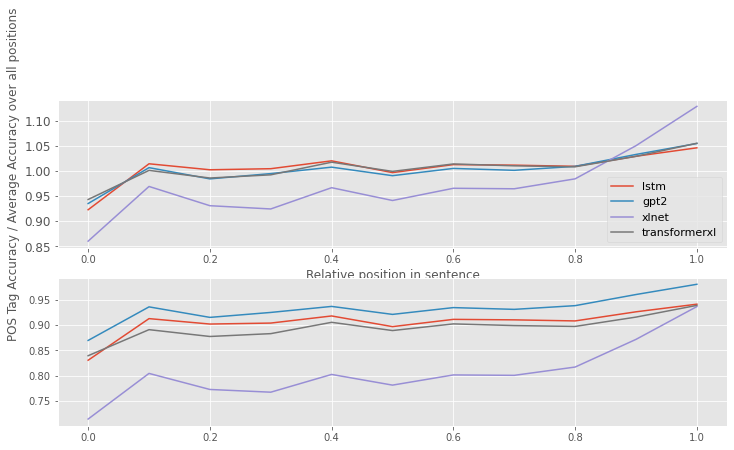

In [114]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,6))
accsLSTM2 = {}
accsGPT2 = {}
accsXLNET2 = {}
accsTXL2 = {}

for z in accsLSTM[0]:
    accsLSTM2[z] = accsLSTM[0][z]/0.9
    
for z in accsGPT[0]:
    accsGPT2[z] = accsGPT[0][z]/0.93

for z in accsXLNET[0]:
    accsXLNET2[z] = accsXLNET[0][z]/0.83
    
for z in accsTXL[0]:
    accsTXL2[z] = accsTXL[0][z]/0.89
    
ax1.plot(*zip(*accsLSTM2.items()), label='lstm')
ax1.plot(*zip(*accsGPT2.items()), label='gpt2')
ax1.plot(*zip(*accsXLNET2.items()), label='xlnet')
ax1.plot(*zip(*accsTXL2.items()), label='transformerxl')


    
ax2.plot(*zip(*accsLSTM[0].items()), label='lstm')
ax2.plot(*zip(*accsGPT[0].items()), label='gpt2')
ax2.plot(*zip(*accsXLNET[0].items()), label='xlnet')
ax2.plot(*zip(*accsTXL[0].items()), label='transformerxl')

#ax2.plot(*zip(*amounts.items()))
#ax1.plot(*zip(*xlnet.items()), label='XLNet')
#ax1.plot(*zip(*txl.items()), label='TransformerXL')
#ax1.plot(*zip(*lrxlnet.items()), label='XLNetLR')
#ax1.plot(*zip(*lrtransformerxl.items()), label='TransformerXLLR')

#ax2.plot(*zip(*ngpt2.items()), label='gpt2')
#ax2.plot(*zip(*nrnn.items()), label='lstm')
#ax2.plot(*zip(*nxlnet.items()), label='xlnet')
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax1.legend(fontsize=11,)
ax1.set_xlabel("Relative position in sentence",fontsize=12)
ax1.set_ylabel("POS Tag Accuracy / Average Accuracy over all positions", fontsize=12)
#plt.savefig('lengths.eps', format='eps',  dpi=1200,  bbox_extra_artists=(z,), bbox_inches='tight')
plt.show()
